In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import os
ldir = os.chdir(r'C:\Users\Ördög Tamás\Downloads')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [2]:
df = sm.datasets.macrodata.load_pandas().data
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [3]:
#2a
df['4q_MA'] = df['realgdp'].rolling(window=4).mean()
df['8q_MA'] = df['realgdp'].rolling(window=8).mean()

In [4]:
#2b
df['double_exp_smoothing'] = df['realgdp'].ewm(alpha=0.2, adjust=False).mean()

In [5]:
#2c
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
gdp_sea = seasonal_decompose(df['realgdp'], model='multiplicative', period=4)

<Axes: >

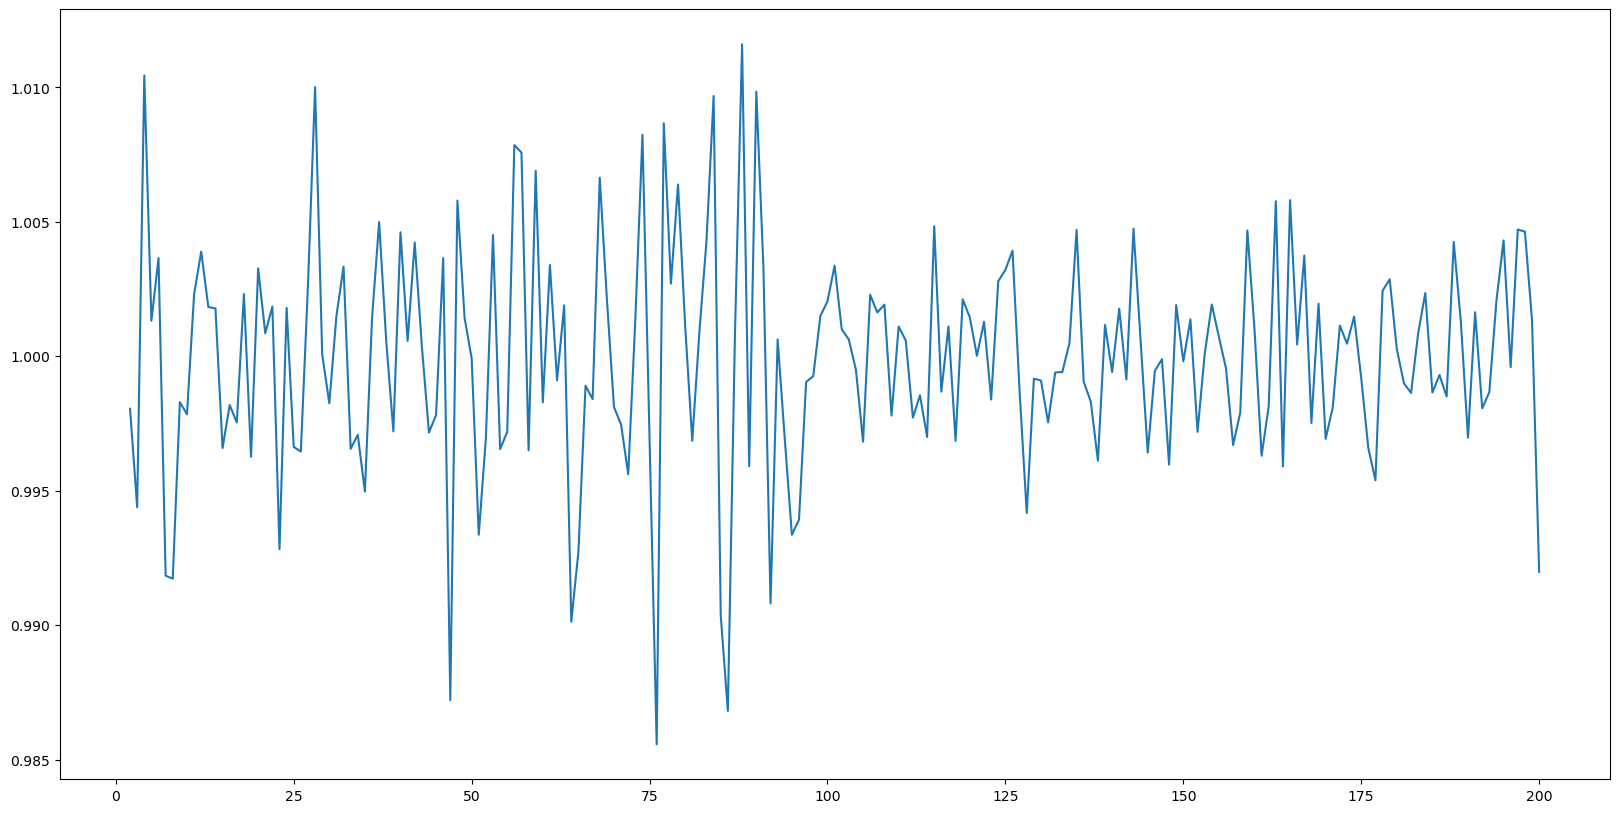

In [7]:
gdp_sea.resid.plot()

In [8]:
ts=gdp_sea.resid.dropna()

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # kiszámítjuk a mozgóátlagot és szórást (12 hónapra)
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    # ábrázoljuk
    orig = plt.plot(timeseries, color = 'blue', label='Orignal')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean 12')
    std = plt.plot(rolstd, color='black', label= 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Elvégezzük Dickey-Fuller tesztet:
    print ("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index= ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s) ' %key] = value
    print(dfoutput)

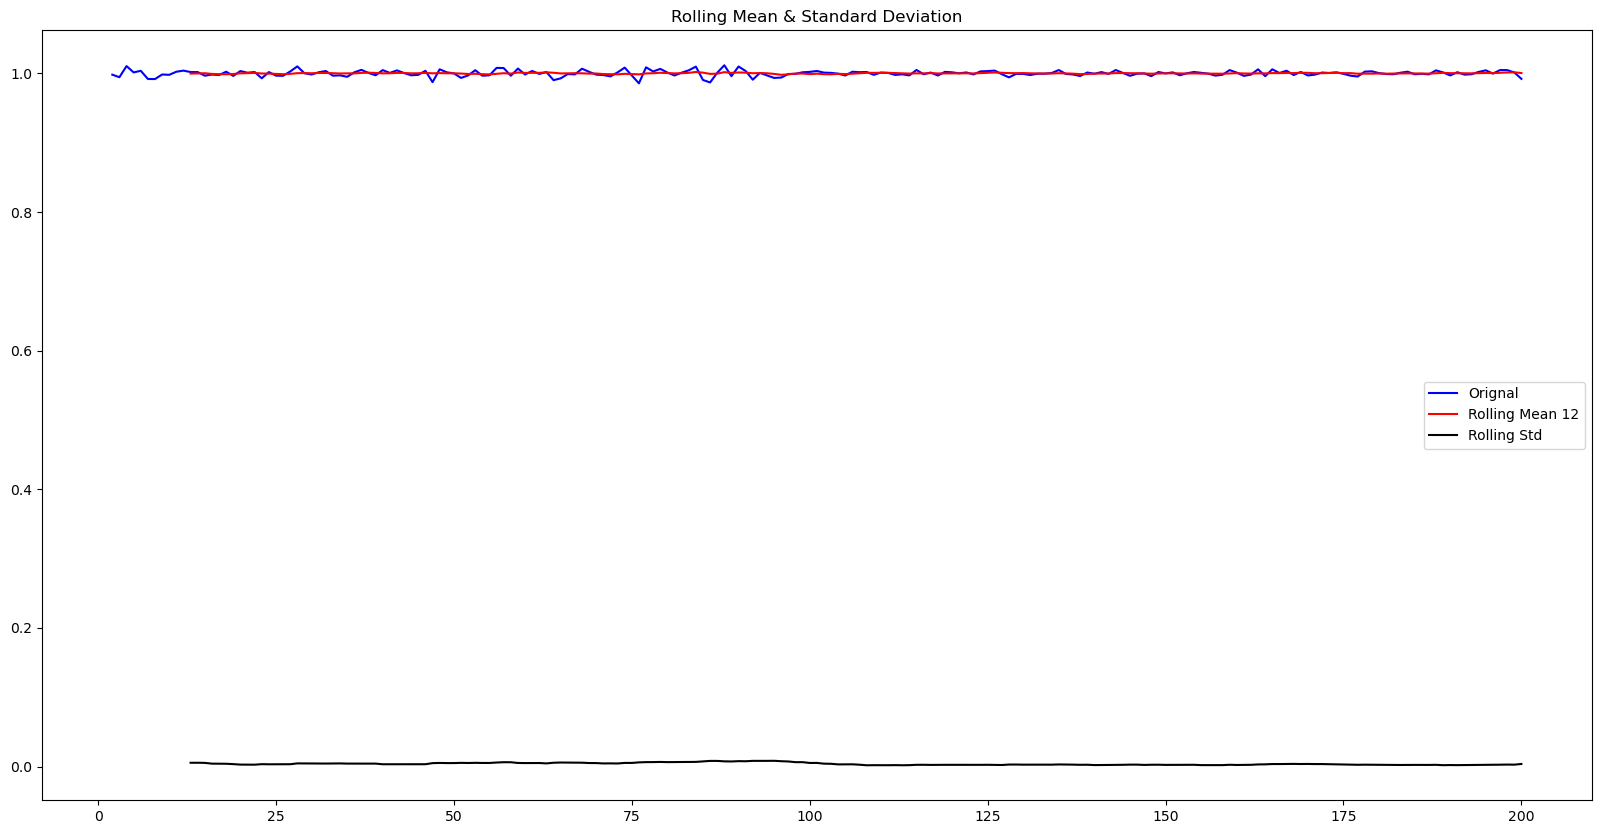

Results of Dickey-Fuller Test:
Test Statistic                -6.025550e+00
p-value                        1.458897e-07
#Lags Used                     1.400000e+01
Number of Observations Used    1.840000e+02
Critical Value (1%)           -3.466398e+00
Critical Value (5%)           -2.877380e+00
Critical Value (10%)          -2.575214e+00
dtype: float64


In [10]:
test_stationarity(ts)

In [11]:
ts_log = np.log(ts)
ts_sqrt = np.sqrt(ts)

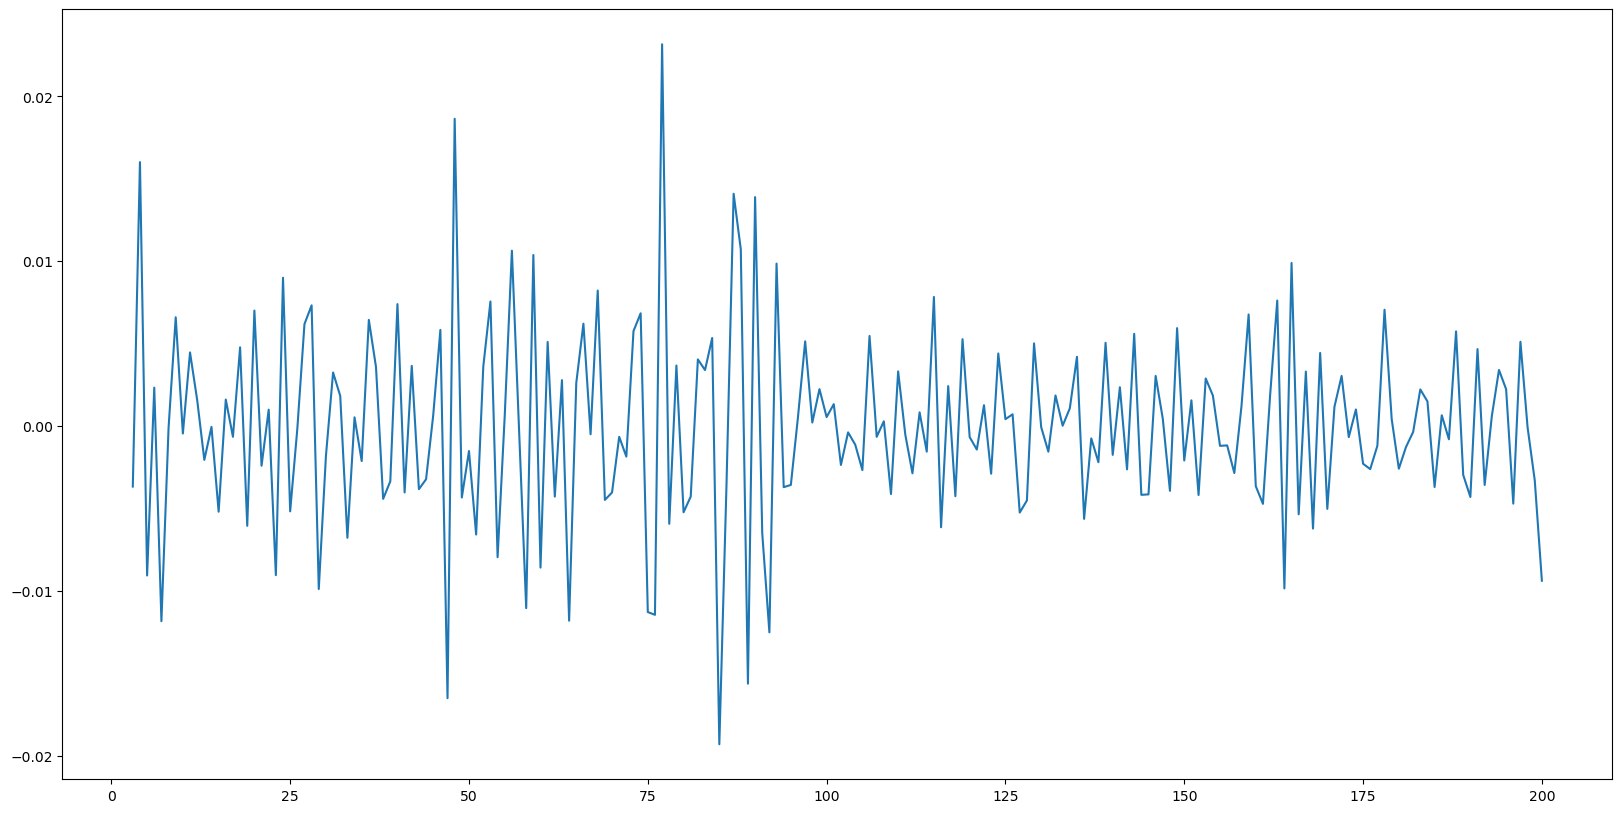

In [12]:
ts_log_diff = ts_log - ts_log.shift(1)
plt.plot(ts_log_diff)

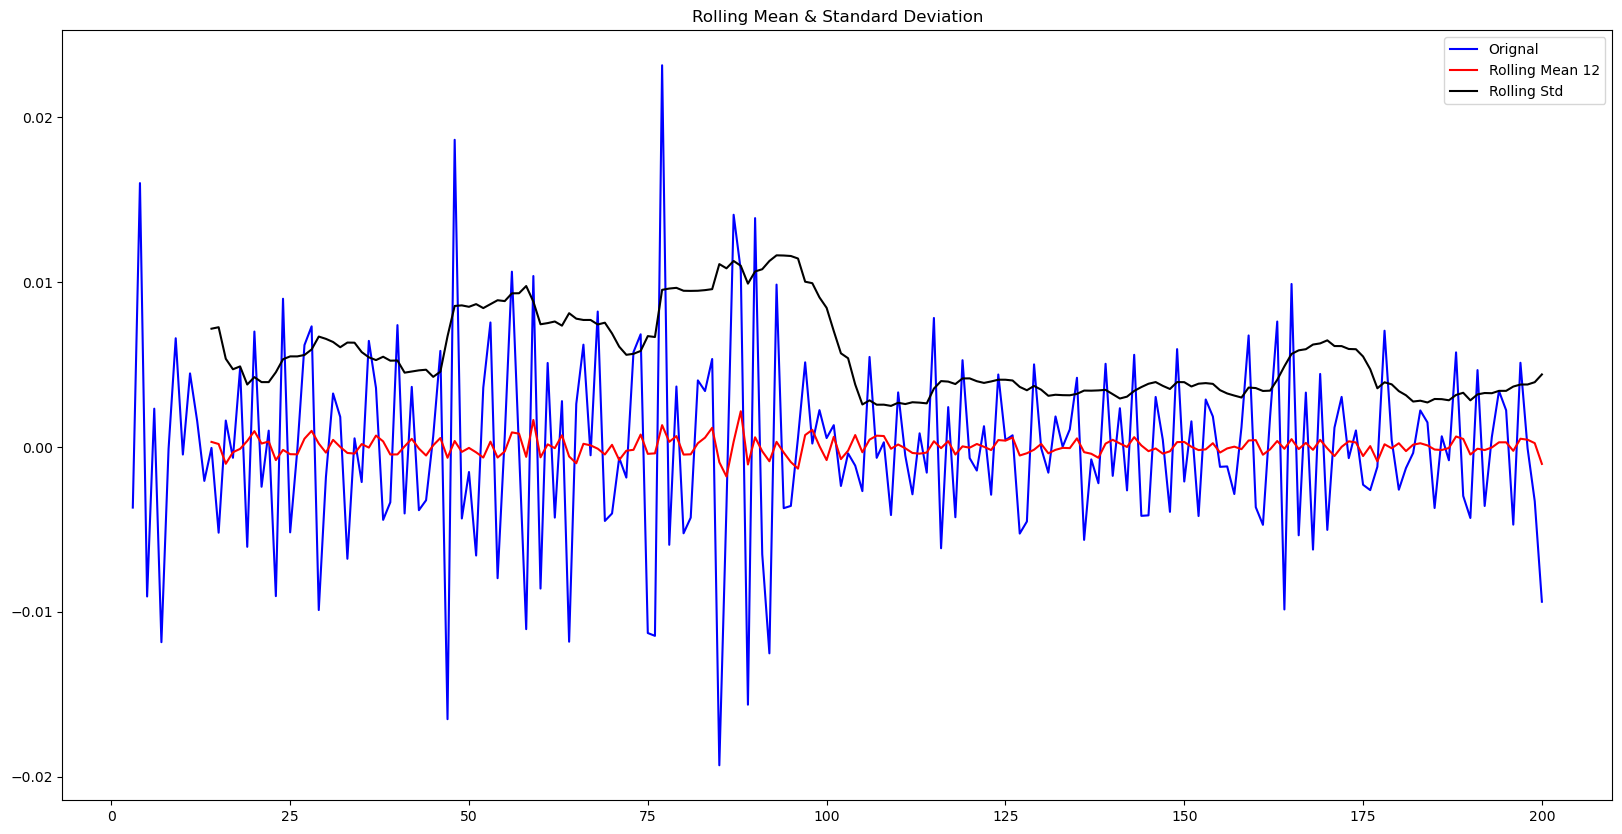

Results of Dickey-Fuller Test:
Test Statistic                -6.996455e+00
p-value                        7.511902e-10
#Lags Used                     1.400000e+01
Number of Observations Used    1.830000e+02
Critical Value (1%)           -3.466598e+00
Critical Value (5%)           -2.877467e+00
Critical Value (10%)          -2.575260e+00
dtype: float64


In [13]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

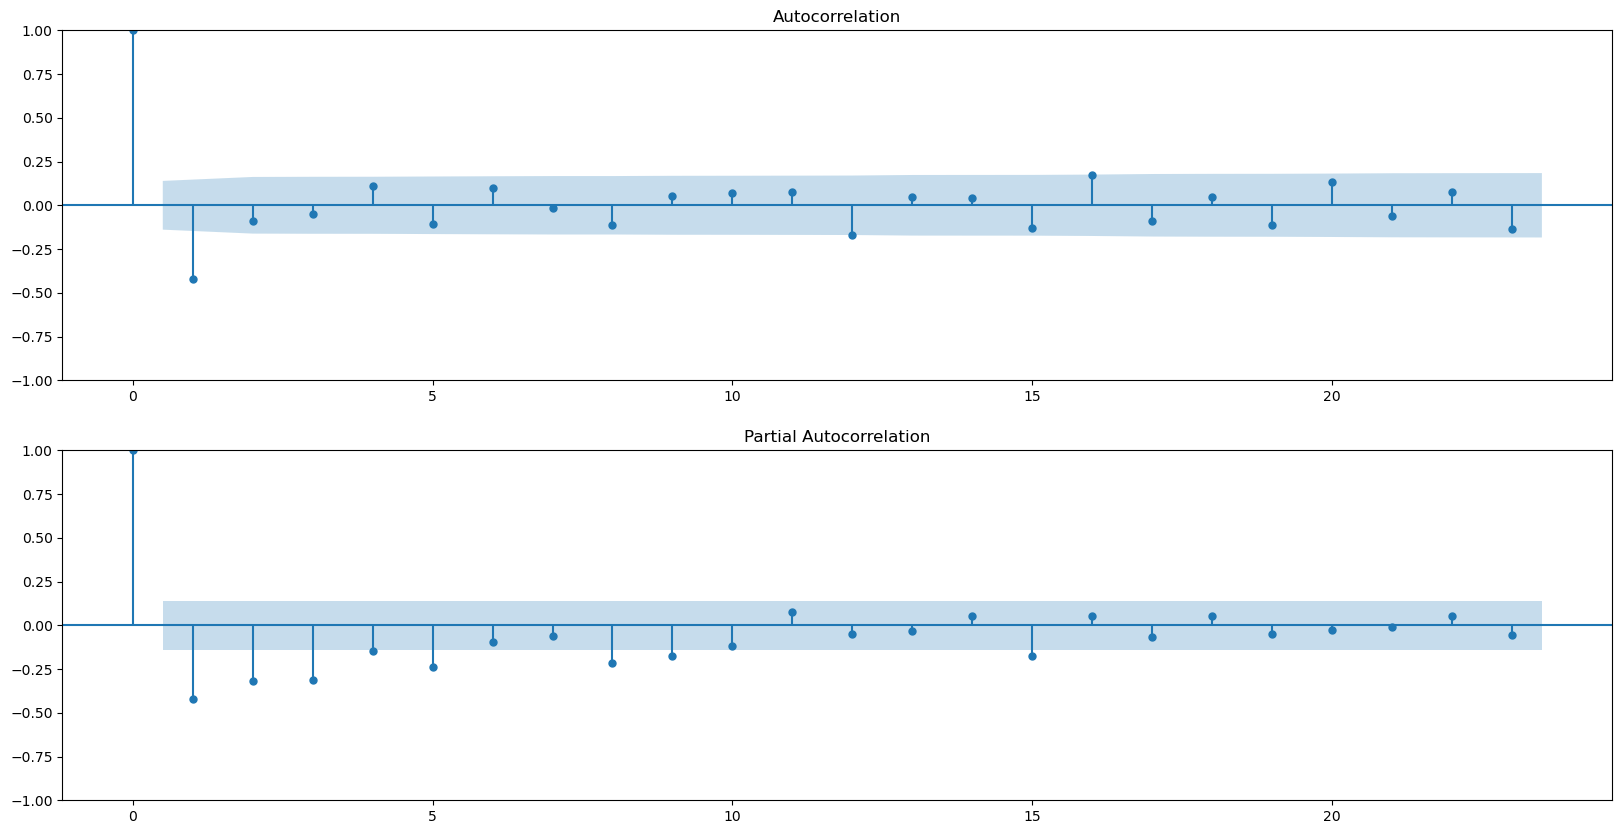

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = ts_log_diff
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

In [15]:
from statsmodels.tsa.arima.model import ARIMA

Text(0.5, 1.0, 'RSS: 0.0085')

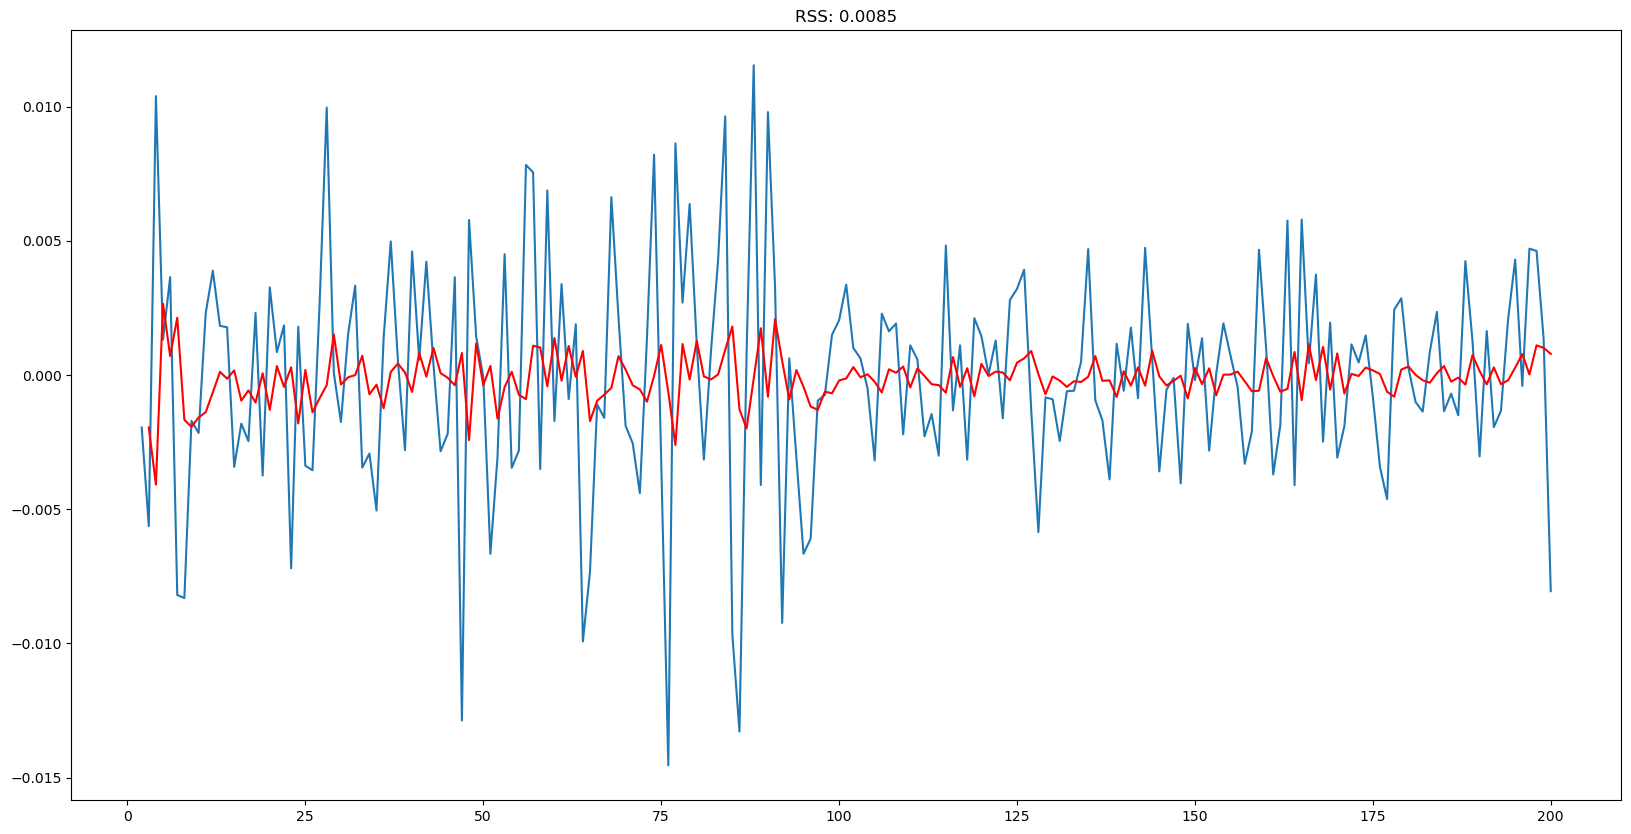

In [16]:
import warnings
warnings.filterwarnings('ignore')
model = ARIMA(ts_log,order=(2,1,2))
result_AR = model.fit()
plt.plot(ts_log)
plt.plot(result_AR.fittedvalues[1:],color='red')
plt.title('RSS: %.4f'%sum((result_AR.fittedvalues[1:] - ts_log_diff)**2))

In [17]:
result_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                  199
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 796.636
Date:                Sun, 24 Mar 2024   AIC                          -1583.273
Time:                        18:38:26   BIC                          -1566.832
Sample:                             0   HQIC                         -1576.618
                                - 199                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6914      0.476     -1.454      0.146      -1.624       0.241
ar.L2          0.0899      0.135      0.668      0.504      -0.174       0.354
ma.L1         -0.1234      0.474     -0.260      0.794      -1.052       0.805
ma.L2         -0.7886      0.483     -1.632      0.103      -1.735       0.158
sigma2      1.851e-05   1.92e-06      9.654      0.000    1.48e-05    2.23e-05
===================================================================================
Ljung-Box (L1) (Q):                   4.09   Jarque-Bera (JB):                14.74
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'RSS: 0.0072')

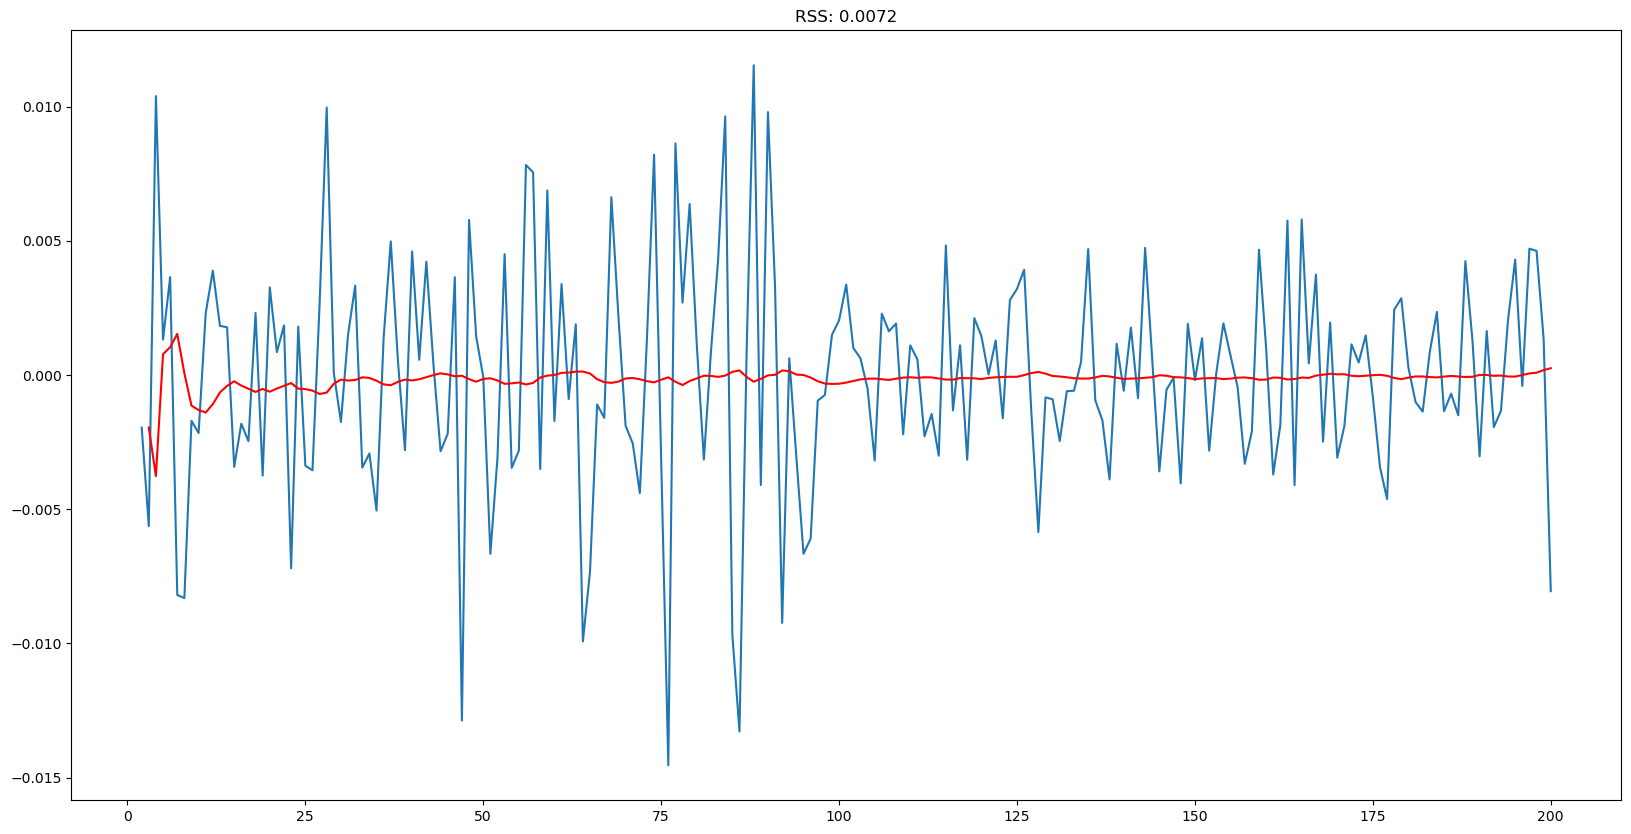

In [18]:
model = ARIMA(ts_log,order=(0,1,2))
result_MA = model.fit()
plt.plot(ts_log)
plt.plot(result_MA.fittedvalues[1:],color='red')
plt.title('RSS: %.4f'%sum((result_MA.fittedvalues[1:] - ts_log_diff)**2))

In [19]:
result_MA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                  199
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 801.344
Date:                Sun, 24 Mar 2024   AIC                          -1596.688
Time:                        18:38:27   BIC                          -1586.824
Sample:                             0   HQIC                         -1592.695
                                - 199                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9933      0.070    -14.275      0.000      -1.130      -0.857
ma.L2          0.0138      0.062      0.222      0.825      -0.108       0.136
sigma2      1.754e-05   1.79e-06      9.777      0.000     1.4e-05    2.11e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                19.04
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
results = []
best_aic = float("inf")
for i in range(5):
    for j in range(5):
        model = ARIMA(ts_log,order=(i,1,j))
        aic = model.fit().aic
        model_fit = model.fit()
        rss = sum((model_fit.fittedvalues-ts_log_diff)**2)
        if aic < best_aic:
            best_model = model
            best_aic = aic
            legj = [i,1,j,best_aic]
        results.append([i,1,j, aic,rss])

In [21]:
for k in results:
    print(k)

[0, 1, 0, -1467.448077025661, nan]
[0, 1, 1, -1554.5261258950363, nan]
[0, 1, 2, -1596.6883948284994, nan]
[0, 1, 3, -1605.7948885789824, nan]
[0, 1, 4, -1608.4782749429, nan]
[1, 1, 0, -1504.1017629427922, nan]
[1, 1, 1, -1598.5256395469069, nan]
[1, 1, 2, -1597.163829117393, nan]
[1, 1, 3, -1595.038664404747, nan]
[1, 1, 4, -1596.5889057215436, nan]
[2, 1, 0, -1524.9354435982182, nan]
[2, 1, 1, -1602.2629820185662, nan]
[2, 1, 2, -1583.2729315037686, nan]
[2, 1, 3, -1592.5648031498813, nan]
[2, 1, 4, -1602.8299559201064, nan]
[3, 1, 0, -1546.0684756016713, nan]
[3, 1, 1, -1554.8680135113705, nan]
[3, 1, 2, -1599.0963261852703, nan]
[3, 1, 3, -1578.4933372419723, nan]
[3, 1, 4, -1593.5408640493238, nan]
[4, 1, 0, -1549.6337047407967, nan]
[4, 1, 1, -1568.7410660148294, nan]
[4, 1, 2, -1595.9308544071232, nan]
[4, 1, 3, -1596.8407876283147, nan]
[4, 1, 4, -1592.0181837651007, nan]


In [22]:
print(legj)

[0, 1, 4, -1608.4782749429]


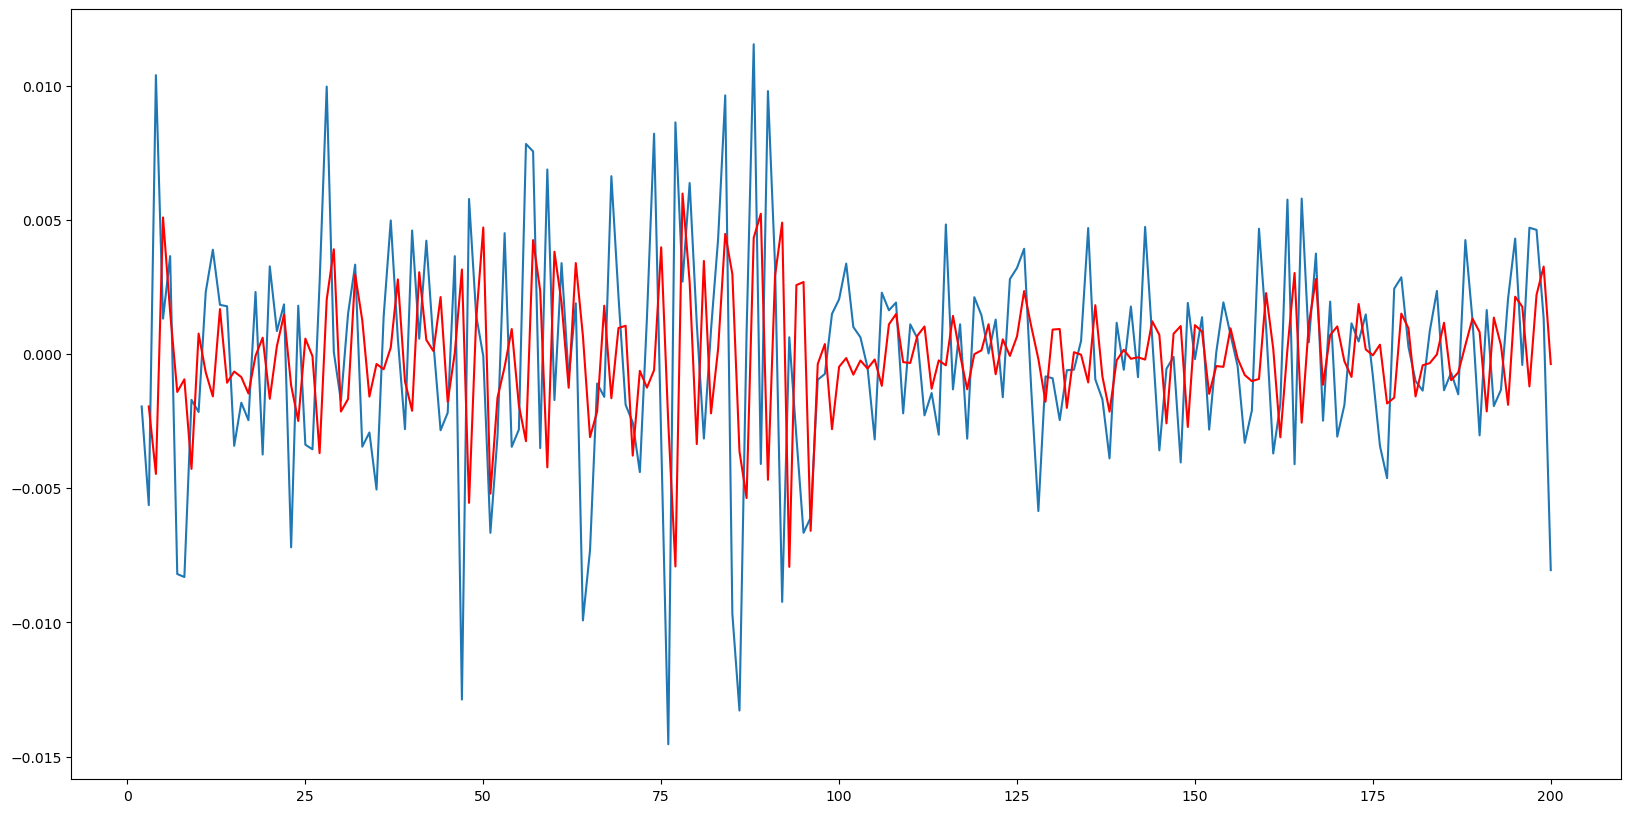

In [23]:
model = ARIMA(ts_log,order=(0,1,4),trend='t')
results_ARIMA = model.fit()
plt.plot(ts_log)
plt.plot(results_ARIMA.fittedvalues[1:], color='red')

In [24]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                  199
Model:                 ARIMA(0, 1, 4)   Log Likelihood                 779.306
Date:                Sun, 24 Mar 2024   AIC                          -1546.612
Time:                        18:38:43   BIC                          -1526.883
Sample:                             0   HQIC                         -1538.626
                                - 199                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.062e-06   7.82e-05      0.026      0.979      -0.000       0.000
ma.L1         -0.5848      0.070     -8.378      0.000      -0.722      -0.448
ma.L2         -0.2042      0.071     -2.867      0.004      -0.344      -0.065
ma.L3         -0.2902      0.060     -4.811      0.000      -0.408      -0.172
ma.L4          0.2877      0.075      3.839      0.000       0.141       0.435
sigma2      2.213e-05    2.4e-06      9.239      0.000    1.74e-05    2.68e-05
===================================================================================
Ljung-Box (L1) (Q):                  16.29   Jarque-Bera (JB):                22.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""